In [14]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print("Directory {} Number of files {}".format(dirname,len(filenames)))



Directory /kaggle/input Number of files 0
Directory /kaggle/input/intel-image-classification Number of files 0
Directory /kaggle/input/intel-image-classification/seg_train Number of files 0
Directory /kaggle/input/intel-image-classification/seg_train/seg_train Number of files 0
Directory /kaggle/input/intel-image-classification/seg_train/seg_train/mountain Number of files 2512
Directory /kaggle/input/intel-image-classification/seg_train/seg_train/street Number of files 2382
Directory /kaggle/input/intel-image-classification/seg_train/seg_train/buildings Number of files 2191
Directory /kaggle/input/intel-image-classification/seg_train/seg_train/sea Number of files 2274
Directory /kaggle/input/intel-image-classification/seg_train/seg_train/forest Number of files 2271
Directory /kaggle/input/intel-image-classification/seg_train/seg_train/glacier Number of files 2404
Directory /kaggle/input/intel-image-classification/seg_pred Number of files 0
Directory /kaggle/input/intel-image-classifica

# Classification using PyTorch

In [15]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler


from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchvision import models

import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
TRAIN_PATH = '../input/intel-image-classification/seg_train/seg_train'
TEST_PATH = '../input/intel-image-classification/seg_test/seg_test'
PRED_PATH = '../input/intel-image-classification/seg_pred/seg_pred'

In [17]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224))
])

In [18]:
train_ds = ImageFolder(TRAIN_PATH, transform=transform)
test_ds = ImageFolder(TEST_PATH, transform=transform)

In [19]:
train_ds.classes

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [20]:
class_len = len(train_ds.classes)

In [21]:
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory=True, num_workers=8)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=True, pin_memory=True, num_workers=8)

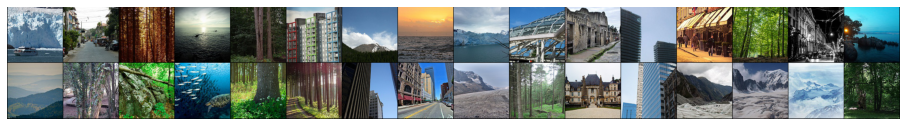

In [22]:
for batch in train_dl:
    plt.figure(figsize=(16, 8))
    image, _ = batch
    plt.imshow(make_grid(image, nrow=16).permute(1, 2, 0))
    plt.axis("off")
    plt.show()
    break

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [24]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, class_len)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [38]:
def accuracy(pred, label):
    _, out = torch.max(pred, dim=1)
    return torch.tensor(torch.sum(out == label).item()/len(pred))

def validation_step(valid_dl, model, loss_fn,device):
    for image, label in valid_dl:
        image = image.to(device)
        label = label.to(device)
        
        out = model(image)
        loss = loss_fn(out, label)
        acc = accuracy(out, label)
        return {"val_loss": loss, "val_acc": acc}
    
def fit(train_dl, valid_dl, epochs, optimizer, loss_fn, model,device):
    history = []
    for epoch in range(epochs):
        for image, label in train_dl:
            image = image.to(device)
            label = label.to(device)
            
            out = model(image)
            loss = loss_fn(out, label)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        val = validation_step(valid_dl, model, loss_fn, device)
        print(f"Epoch [{epoch}/{epochs}] => loss: {loss}, val_loss: {val['val_loss']}, val_acc: {val['val_acc']}")
        history.append({"loss": loss, 
                        "val_loss": val['val_loss'], 
                        "val_acc": val['val_acc']
                       })
    return history

In [39]:
device

device(type='cuda', index=0)

In [40]:
history = fit(train_dl, test_dl, 5, optimizer_ft, criterion, model_ft,device)

Epoch [0/5] => loss: 0.02310429885983467, val_loss: 0.22603100538253784, val_acc: 0.90625
Epoch [1/5] => loss: 0.03230319917201996, val_loss: 0.5113784670829773, val_acc: 0.875
Epoch [2/5] => loss: 0.007359969895333052, val_loss: 0.04117584228515625, val_acc: 1.0
Epoch [3/5] => loss: 0.06922386586666107, val_loss: 0.18466879427433014, val_acc: 0.96875
Epoch [4/5] => loss: 0.002360426587983966, val_loss: 0.3597767651081085, val_acc: 0.875


In [41]:
model_ft.fit(train_dl,epochs=5)

ModuleAttributeError: 'ResNet' object has no attribute 'fit'